+ https://github.com/JuliaAcademy/DataScience/blob/master/09.%20Numerical%20Optimization.ipynb

In [54]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("GLPK")
Pkg.resolve()

mkpath("downloads")
mkpath("out")

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\appunti\Project.toml`
  Resolving package versions...
  Installed GLPK_jll ─ v4.64.0+0
  Installed GMP_jll ── v6.1.2+5
  Installed GLPK ───── v0.13.0
Updating `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\appunti\Project.toml`
  [60bf3e95] + GLPK v0.13.0
Updating `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\appunti\Manifest.toml`
  [60bf3e95] + GLPK v0.13.0
  [e8aa6df9] + GLPK_jll v4.64.0+0
  [781609d7] + GMP_jll v6.1.2+5
   Building GLPK → `C:\Users\i am\.julia\packages\GLPK\oTTtu\deps\build.log`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\appunti\Project.toml`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\appunti\Manifest.toml`


"out"

In [55]:
using Pkg
using Convex
using SCS
using XLSX
using DataFrames
using Plots
using CSV
using Statistics
using Images
using DelimitedFiles
using JuMP
using GLPK

┌ Info: Precompiling GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1278


In [6]:
# portfolio investment (è tipo knapsack non binario)
# https://www.kdnuggets.com/2019/06/optimization-python-money-risk.html


In [8]:
download("https://github.com/JuliaAcademy/DataScience/blob/master/data/stock_prices.xlsx?raw=true", "downloads/stock_prices.xlsx")

"downloads/stock_prices.xlsx"

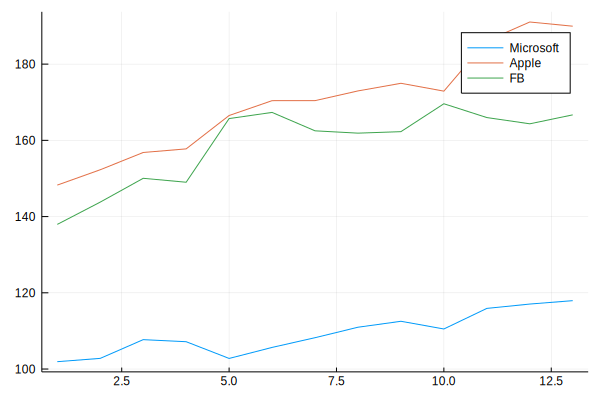

In [11]:
T = DataFrame(XLSX.readtable("downloads/stock_prices.xlsx","Sheet2")...)
# T è df con andamento prezzo azioni microsoft,apple,facebook
# plottiamo
plot(T[!,:MSFT],label="Microsoft")
plot!(T[!,:AAPL],label="Apple")
plot!(T[!,:FB],label="FB")


In [12]:
# per risolvere il problema di ottimizzazione dobbiamo convertirein matrice
prices_matrix = Matrix(T)

13×3 Array{Any,2}:
 101.93  137.95  148.26
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
 105.67  167.33  170.41
 108.22  162.5   170.42
 110.97  161.89  172.97
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05
 117.94  166.69  189.95

In [13]:
#calcoliamo il ritorno di investiento settimanale
M1 = prices_matrix[1:end-1,:]
M2 = prices_matrix[2:end,:]
R = (M2.-M1)./M1

12×3 Array{Float64,2}:
  0.00853527   0.0424067    0.027182
  0.0477626    0.0433936    0.0297459
 -0.00501346  -0.00686484   0.00599413
 -0.040963     0.112073     0.0555274
  0.0281183    0.00977611   0.0233606
  0.0241317   -0.0288651    5.8682e-5
  0.0254112   -0.00375385   0.014963
  0.0140579    0.00240904   0.0115627
 -0.0179508    0.0451072   -0.0117734
  0.0488644   -0.0213443    0.0763981
  0.00983522  -0.00988071   0.0264883
  0.00760359   0.0142996   -0.00575766

In [14]:
#definiamo il ns problema:
#vogliamo massimizzare il ritorno definito come funzione di investimenti sulle e ritorni delle varie azioni
# max dot(r,x) x=[x1,x2,x3] x1=investimento msft, x2= investimento aapl, x3 = investimento fb
# r=[r1,r2,r3], r1= ritorno msft, r2=ritorno aapl, r3=ritorno fb
# con vincoli x_1,2,3 >= 0, sum(x)=1 , x sono le percentuali di investimento

# r è var aleat che modelleremo secondo valore atteso. E[dot(r,x)] = E[dot(mean(R,dims=2),x)
#dot(r,x)=0.1 significa ritorno sull investimento del 10%

# ci serve matrice rischio che sarà matrice covarianza
risk_matrix = cov(R)
# note that the risk matrix is positive definite
isposdef(risk_matrix)

true

In [15]:
r = mean(R,dims=1)[:]
# come gia detto andiamo con il valore atteso

3-element Array{Float64,1}:
 0.012532748705136572
 0.016563036855293173
 0.02114580465503291

In [16]:
#risolviamo il problema minimizzando il rischio x'*risk_matrix*x
#essendo problema convesso risolvibile con pkg convex.jl
x = Variable(length(r))
problem = minimize(x'*risk_matrix*x,[sum(x)==1;r'*x>=0.02;x.>=0])

minimize
└─ * (Convex.NotDcp; real)
   ├─ * (affine; real)
   │  ├─ adjoint (affine; real)
   │  │  └─ …
   │  └─ 3×3 Array{Float64,2}
   └─ 3-element real variable (id: 141…092)
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 141…092)
   └─ 0

status: `solve!` not called yet

┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\i am\.julia\packages\Convex\aYxJA\src\dcp.jl:25


In [17]:
#convex.jl rischiede che input sia problema definito dcp (seguire http://cvxr.com/cvx/doc/dcp.html )
# riscriviamolo tale
problem = minimize(Convex.quadform(x,risk_matrix),[sum(x)==1;r'*x>=0.02;x.>=0])

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 141…092)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 141…092)
   └─ 0

status: `solve!` not called yet

In [18]:
#possiamo ora risolverlo
solve!(problem, SCS.Optimizer)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 24, CG tol ~ 1/iter^(2.00)
eps = 1.00e-005, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 6, constraints m = 14
Cones:	primal zero / dual free vars: 2
	linear vars: 5
	soc vars: 7, soc blks: 2
Setup time: 4.98e-005s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|1.71e+019 2.86e+019 1.00e+000 -3.40e+019 5.17e+018 5.49e+019 2.10e-005 
    97|4.78e-011 1.28e-010 1.08e-010 4.85e-004 4.85e-004 3.76e-017 2.48e-003 
-------------------------------------------

In [19]:
#vediamo i risultati
x

Variable
size: (3, 1)
sign: real
vexity: affine
id: 141…092
value: [0.06795414742252917, 0.12230857118794068, 0.8097372814405625]

In [20]:
sum(x.value)

1.0000000000510323

In [23]:
# return 
returnperc = ((r'*x.value)*100)[1]

investments = x.value .* 1000
println("ritorno massimo previsto del $returnperc %, investendo $(investments[1]) \$ in MSFT, investendo $(investments[2]) \$ in AAPL E investendo $(investments[3]) \$ in FB, ")

ritorno massimo previsto del 2.0000000000662013 %, investendo 67.95414742252918 $ in MSFT, investendo 122.30857118794069 $ in AAPL E investendo 809.7372814405625 $ in FB, 


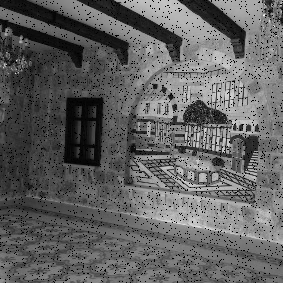

In [45]:
#### PROB 2 IMAGE RECOVERY
# carichiamo un imm
download("https://github.com/JuliaAcademy/DataScience/blob/master/data/khiam-small.jpg?raw=true", "downloads/khiam-small.jpg")
Kref = load("downloads/khiam-small.jpg")
K = copy(Kref)
Gray.(K)

#creiamo dei pixel mancanti

p = prod(size(K))
missingids = rand(1:p,4000)
K[missingids] .= RGBX{N0f8}(0.0,0.0,0.0)
gK =Gray.(K)

In [46]:
#portiamo tutto in una mat come al solito
Y = Float64.(gK);

In [47]:
# il problema ora è nel ricostruire la matrice
#l algoritmo che useremo fa ciò creando mat X con norma nucleare minima e mantenendo i valori conosciuti di Y ugualiin X
#solviamo ancora con convex.jl
correctids = findall(Y[:].!=0)
X = Convex.Variable(size(Y))
problem = minimize(nuclearnorm(X))
problem.constraints += X[correctids]==Y[correctids]

1-element Array{Constraint,1}:
 == constraint (affine)
├─ index (affine; real)
│  └─ 283×283 real variable (id: 897…053)
└─ 76188-element Array{Float64,1}

In [48]:
solve!(problem, SCS.Optimizer(eps=1e-3, alpha=1.5))

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 396828, CG tol ~ 1/iter^(2.00)
eps = 1.00e-003, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 240268, constraints m = 396545
Cones:	primal zero / dual free vars: 236084
	sd vars: 160461, sd blks: 1
Setup time: 6.21e-002s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|1.04e+021 5.63e+019 1.00e+000 -1.51e+024 1.40e+022 1.13e+024 2.56e-001 
   100|2.95e-002 1.50e-002 9.31e-006 4.35e+002 4.35e+002 3.91e-015 2.37e+001 
   200|1.03e-002 5.65e-003 7.87e-005 4

norm(float.(Gray.(Kref)) - X.value) = 3.79080287028465
norm(-(X.value)) = 124.21420761207698


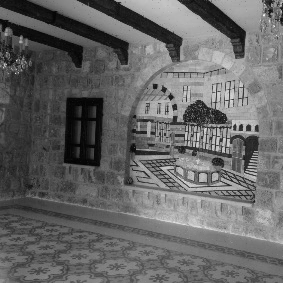

In [49]:

@show norm(float.(Gray.(Kref))-X.value)
@show norm(-X.value)
colorview(Gray, X.value)

In [56]:
# ottimizzazione dieta
# esemnpio da jump.jl https://github.com/jump-dev/JuMP.jl/blob/master/examples/diet.jl
category_data = JuMP.Containers.DenseAxisArray(
    [1800 2200;
     91   Inf;
     0    65;
     0    1779], 
    ["calories", "protein", "fat", "sodium"], 
    ["min", "max"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
    Dimension 2, ["min", "max"]
And data, a 4×2 Array{Float64,2}:
 1800.0  2200.0
   91.0    Inf
    0.0    65.0
    0.0  1779.0

| | min | max|
|---|---|---|
|calories|1800|2200|
|protein| 91|inf|
|fat|0|65|
|sodium|0|1779|

è matrice 1800,91,0,0,2200,inf,65,1779 dove min,max sono indici colonne e calories,prot,etc sono indici righe

In [57]:
@show category_data["calories","max"] 
@show category_data["fat","min"]
;

category_data["calories", "max"] = 2200.0
category_data["fat", "min"] = 0.0


In [58]:
# ora facciamo dataset per prezzi alimenti
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]
cost = JuMP.Containers.DenseAxisArray(
    [2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59],
    foods)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
And data, a 9-element Array{Float64,1}:
 2.49
 2.89
 1.5
 1.89
 2.09
 1.99
 2.49
 0.89
 1.59

In [59]:
#ora facciamo dataset caratt nutriz stessi alimenti
food_data = JuMP.Containers.DenseAxisArray(
    [410 24 26 730;#una riga è una riga contenente valori per "calories", "protein", "fat", "sodium" dell alimento
     420 32 10 1190;
     560 20 32 1800;
     380  4 19 270;
     320 12 10 930;
     320 15 12 820;
     320 31 12 1230;
     100  8 2.5 125;
     330  8 10 180], 
    foods, 
    ["calories", "protein", "fat", "sodium"])

@show food_data["chicken", "fat"]
@show food_data["milk", "sodium"]
;

food_data["chicken", "fat"] = 10.0
food_data["milk", "sodium"] = 125.0


In [ ]:
#creiamo il modello ora